# Informacje o procesorze

In [56]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 12 15:30:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0              32W /  70W |   8575MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Instalacja i wersje pakietów

In [57]:
pip install colorama

In [58]:
pip install keras

In [59]:
!pip install scikit-learn

In [60]:
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from colorama import Fore

In [ ]:
!python --version
print('Keras: ', keras.__version__)
print('Tensorflow: ', tf.__version__)
print('Pandas: ', pd.__version__)
print('NumPy: ', np.__version__)
print('Seaborn: ', sns.__version__)
print('Matplotlib: ', matplotlib.__version__)

Python 3.10.12
Keras:  2.15.0
Tensorflow:  2.15.0
Pandas:  2.0.3
NumPy:  1.25.2
Seaborn:  0.13.1
Matplotlib:  3.7.1


# Pobranie zestawu danych



In [61]:
# Pobranie danych MNIST z biblioteki Keras
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Łączenie zestawu treningowego i testowego
images = np.concatenate((train_images, test_images))
labels = np.concatenate((train_labels, test_labels))

print(f'Rozmiar zbioru danych: {images.shape}')
print(f'{Fore.GREEN}Obrazy zostały załadowane pomyślnie!{Fore.BLACK}')

Rozmiar zbioru danych: (70000, 28, 28)
Obrazy zostały załadowane pomyślnie!


# Funkcje niestandardowe

___

## Operacje na danych

In [62]:
def shuffle_data(images: np.ndarray, labels: np.ndarray, random_seed: int, size: int) -> list:
    """Konwersja obrazów do 3-kanałowego typu RGB,
       zmiana rozmiaru obrazów wejściowych w celu dopasowania do wybranego modelu oraz
       normalizacja obrazów do wartości w przedziale [0, 255]

    Args:
        images (np.ndarray): Dane wejściowe
        labels (np.ndarray): Etykiety
        random_seed (int): Ziarno ustalone w celu mozliwości odtworzenia wyników
        size (int): Ilość danych wejściowych

    Returns:
        (tuple): (sampled_images, sampled_labels)
    """
    # Zapewnienie odtwarzalności
    np.random.seed(random_seed)

    # Tasowanie indeksów w celu losowego wyboru danych
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)

    # Wybór określonej liczby próbek
    selected_indices = indices[:size]

    return images[selected_indices], labels[selected_indices]

In [63]:
def resize_images(images: np.ndarray, shape:list) -> tf.Tensor:
  """Konwersja obrazów do 3-kanałowego typu RGB,
     zmiana rozmiaru obrazów wejściowych w celu dopasowania do wybranego modelu oraz
     normalizacja obrazów do wartości w przedziale [0, 255]

  Args:
      images (np.ndarray): Dane wejściowe
      shape (list): Nowy rozmiar obrazu

  Returns:
      images_resized: tf.Tensor
  """
  # Przekształcenie w RGB (3 kanały)
  images_rgb = np.repeat(images[..., np.newaxis], 3, axis=-1)
  # Zmiana rozmiaru
  images_resized = tf.image.resize(images_rgb, shape)
  # Normalizacja
  images_resized /= 255.0

  return images_resized

## Budowa modeli CNN

In [64]:
from keras.applications import VGG16, VGG19
from keras import layers, models

def build_VGG_model(model_type: str):
  # Utworzenie modelu VGG16 z wstępnie wytrenowanego na danych ImageNet, z wyłączeniem górnych w pełni połączonych warstw.
  if model_type == 'VGG16':
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
  elif model_type == 'VGG19':
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
  else:
    raise ValueError("Wrong value! model value must be 'VGG16' or 'VGG19'")

  # Zamrożenie warstw modelu bazowego, aby zapobiec ich aktualizacji podczas pierwszej fazy treningu.
  for layer in base_model.layers:
      layer.trainable = False

  # Stworzenie modelu
  model = models.Sequential()

  # Dodanie przetrenowanej architektury modelu VGG16
  model.add(base_model)

  # Dodanie nowej warswy wyjściowej
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(10, activation='softmax')) # 10 klas dla klasyfikacji cyfr

  # Kompilacja modelu
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  model.summary()

  return model

In [65]:
import time

def train_model(model, x_train, y_train, val_data, epochs) -> list:
  """Trening modelu na danych wejściowych, z pomiarem czasu

  Args:
      model (keras.models): Architektura sieci modelu
      x_train (list): Nowy rozmiar obrazu
      x_train (list): Nowy rozmiar obrazu
      x_train (list): Nowy rozmiar obrazu

  Returns:
      images_resized: tf.Tensor
  """
  # Start pomiaru czasu
  start_time = time.time()

  # Trening modelu
  history = model.fit(x_train, y_train,
                      epochs=epochs,
                      batch_size=64,
                      validation_data=val_data,
                      verbose=1)

  # Stop pomiaru czasu
  end_time = time.time()
  training_time = end_time - start_time
  print(f"Trening ukończony w przeciągu: {training_time:.2f} sekund")

  return history, training_time

In [66]:
def predict(model, x_test):
  start_time = time.time()

  # Make predictions on the test set
  predictions = model.predict(x_test)

  end_time = time.time()
  predicting_time = end_time - start_time
  print(f"Prediction completed in: {predicting_time:.2f} seconds")

  return predictions, predicting_time

## Wykresy i funkcje pomocnicze

In [67]:
INDEXES = ["Czas treningu", "Czas klasyfikacji", "Dokładność treningowa", "Dokładność walidacyjna", "Strata treningowa", "Strata walidacyjna"]

def create_df(output_data: dict) -> pd.DataFrame:
  return pd.DataFrame(output_data, index=INDEXES)

In [68]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history) -> None:
    """ Tworzenie wykresów dokładności i straty dla modelu

    Args:
        history (model): Wytrenowany model
    """
    def change_to_percent(elements):
      return [i*100 for i in elements]

    # Wykresy dokładności i straty
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    # Wykres dokładności modelu
    axs[0].plot(change_to_percent(history.history['accuracy']), label=f'Dokładność testowa')
    axs[0].plot(change_to_percent(history.history['val_accuracy']), label='Dokładność walidacyjna')
    axs[0].set_title(f'Dokładność modelu')
    axs[0].set_ylabel('Dokładność')
    axs[0].set_xlabel('Liczba epok')
    axs[0].legend(loc='lower right')

    # Wykres starty
    axs[1].plot(change_to_percent(history.history['loss']), label='Strata treningowa')
    axs[1].plot(change_to_percent(history.history['val_loss']), label='Strata walidacyjna')
    axs[1].set_title(f'Strata modelu')
    axs[1].set_ylabel('Strata')
    axs[1].set_xlabel('Liczba epok')
    axs[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [69]:
def plot_results(model_df: pd.DataFrame) -> None:
  # Transpozycja DataFrame dla łatwiejszego plotowania
  df_t = model_df.T

  # Tworzenie wykresu
  plt.figure(figsize=(10, 6))

  # Plotowanie dokładności
  plt.plot(df_t.index, df_t["Dokładność treningowa"], '-o', label='Dokładność testowa', color='red')
  plt.plot(df_t.index, df_t["Dokładność walidacyjna"], '-o', label='Dokładność walidacyjna', color='orange')

  # Plotowanie straty
  plt.plot(df_t.index, df_t["Strata treningowa"], '-o', label='Strata testowa', color='blue')
  plt.plot(df_t.index, df_t["Strata walidacyjna"], '-o', label='Strata walidacyjna', color='green')

  # Dodanie tytułu i etykiet
  plt.title('Dokładność i strata w zależności od ilości danych wejściowych')
  plt.xlabel('Ilość danych wejściowych')
  plt.ylabel('Wartości')

  # Dodanie legendy
  plt.legend()

  # Pokazanie wykresu
  plt.show()

In [70]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def custom_confusion_matrix(true_classes, predicted_classes):
  # Create the confusion matrix
  cm = confusion_matrix(true_classes, predicted_classes)

  # Plot the confusion matrix using Seaborn
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
  plt.xlabel('Etykiety przewidziane przez model')
  plt.ylabel('Etykiety rzeczywiste')
  plt.title('Macierz ')
  plt.show()

In [71]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

def area_under_the_curve(predictions):

  # Binarize the labels in a one-vs-all fashion
  n_classes = y_test.shape[1]
  y_test_binarized = label_binarize(y_test, classes=[*range(n_classes)])

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Optionally, compute the micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), predictions.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Calculate the average AUC
  average_auc = np.mean([roc_auc[i] for i in range(n_classes)])
  print(f'Average AUC: {average_auc:.4f}\n')

  for i in range(n_classes):
    print(f'AUC for class {i}:', round(roc_auc[i]*100, 3))

  return roc_auc, fpr, tpr


In [72]:
import matplotlib.pyplot as plt

def ROC_curve(roc_auc, fpr, tpr):

  plt.figure()
  lw = 2
  colors = plt.cm.rainbow(np.linspace(0, 1, 10))

  plt.plot(fpr[2], tpr[2], color=colors[8], lw=lw, label=f'Krzywa ROC dla klasy 2 (AUC = {roc_auc[2]:.4f})')

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Wartości False Positive')
  plt.ylabel('Wartości True Positive')
  plt.title('Krzywa ROC dla klasy 2')
  plt.legend(loc="lower right")
  plt.show()

In [73]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def compute_metrics(true_classes, predicted_classes):

  # Precision
  precision = precision_score(true_classes, predicted_classes, average='macro')
  print(f'Precision: {precision}')

  # Recall
  recall = recall_score(true_classes, predicted_classes, average='macro')
  print(f'Recall: {recall}')

  # F1 Score
  f1 = f1_score(true_classes, predicted_classes,  average='macro')
  print(f'F1 Score: {f1}')

In [74]:
# Ustawienie ziarna dla reprodukowalności
np.random.seed(42)

# Generowanie losowej liczby całkowitej z przedziału od 0 do 100
seeds = [np.random.randint(0, 101) for i in range(0, 5)]
seeds

[51, 92, 14, 71, 60]

# VGG 16

___


 ----------------------------------------   Model VGG16/1  ---------------------------------------- 


 ----------------------------------------  Tworzenie modelu VGG16/1  ---------------------------------------- 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 10)                2570      
                                    

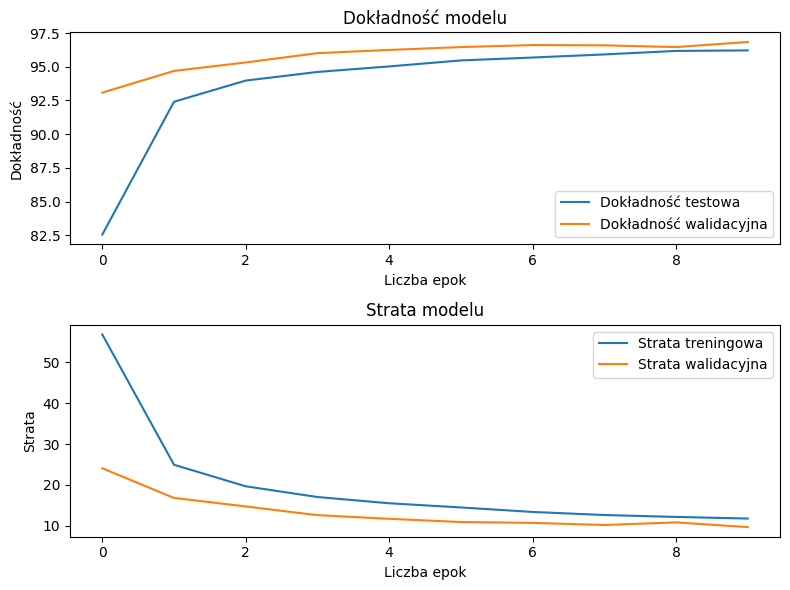


 ----------------------------------------  Testowanie modelu VGG16/1  ---------------------------------------- 

313/313 [==============================] - 2s 7ms/step
Prediction completed in: 2.40 seconds

 ----------------------------------------  Macierz pomyłek VGG16/1  ---------------------------------------- 



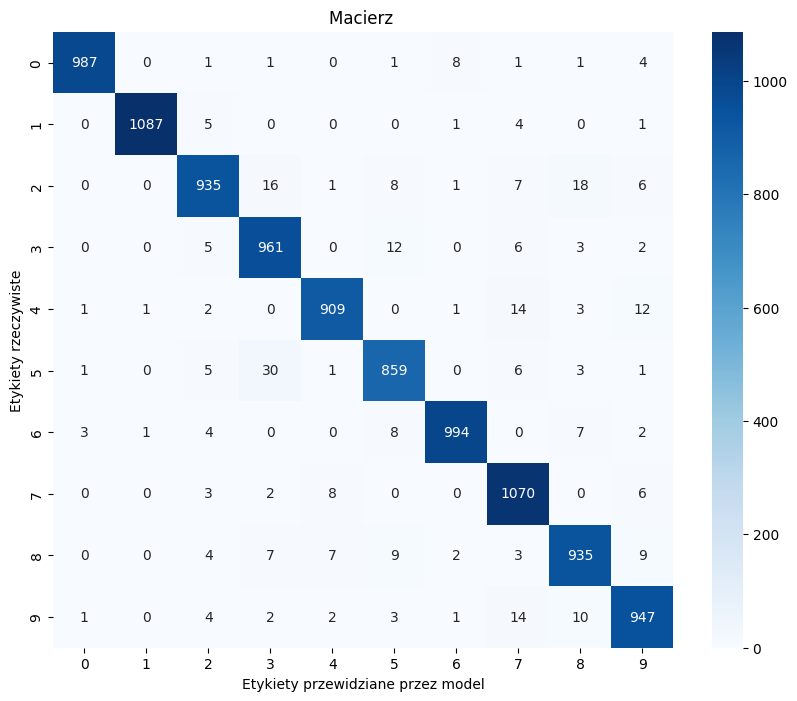


 ----------------------------------------  AUC i ROC VGG16/1  ---------------------------------------- 

Average AUC: 0.9993

AUC for class 0: 99.989
AUC for class 1: 99.993
AUC for class 2: 99.875
AUC for class 3: 99.889
AUC for class 4: 99.94
AUC for class 5: 99.881
AUC for class 6: 99.981
AUC for class 7: 99.957
AUC for class 8: 99.913
AUC for class 9: 99.902


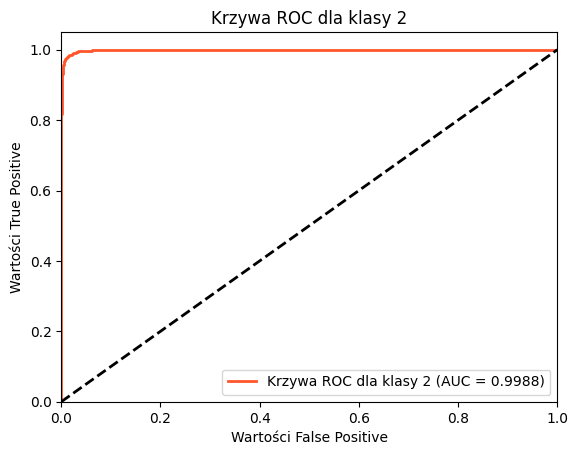


 ----------------------------------------  Metryki pomiarowe VGG16/1  ---------------------------------------- 

Precision: 0.9682951517904158
Recall: 0.9677756009469249
F1 Score: 0.9679579837211841

 ----------------------------------------   Model VGG16/2  ---------------------------------------- 


 ----------------------------------------  Tworzenie modelu VGG16/2  ---------------------------------------- 

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None

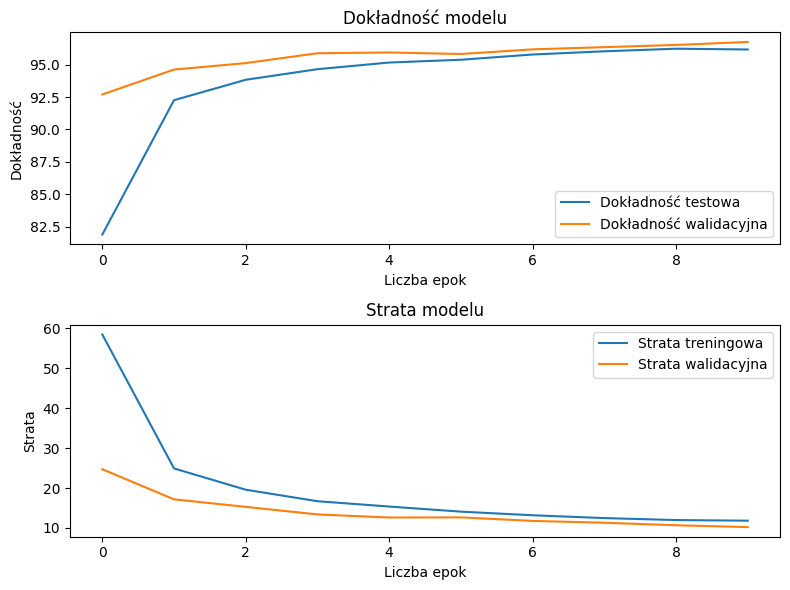


 ----------------------------------------  Testowanie modelu VGG16/2  ---------------------------------------- 

313/313 [==============================] - 2s 7ms/step
Prediction completed in: 2.40 seconds

 ----------------------------------------  Macierz pomyłek VGG16/2  ---------------------------------------- 



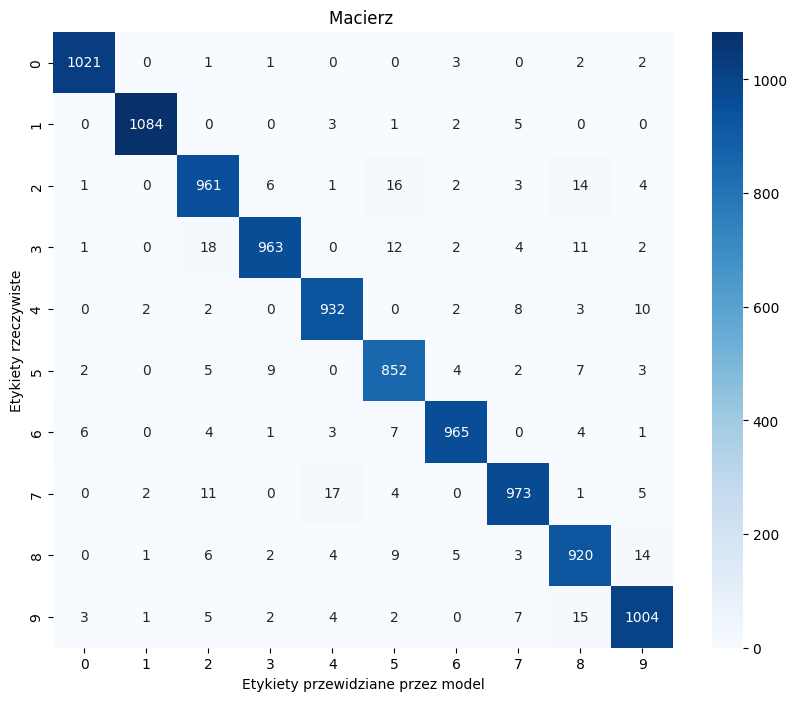


 ----------------------------------------  AUC i ROC VGG16/2  ---------------------------------------- 

Average AUC: 0.9992

AUC for class 0: 99.979
AUC for class 1: 99.997
AUC for class 2: 99.849
AUC for class 3: 99.899
AUC for class 4: 99.933
AUC for class 5: 99.858
AUC for class 6: 99.977
AUC for class 7: 99.941
AUC for class 8: 99.846
AUC for class 9: 99.878


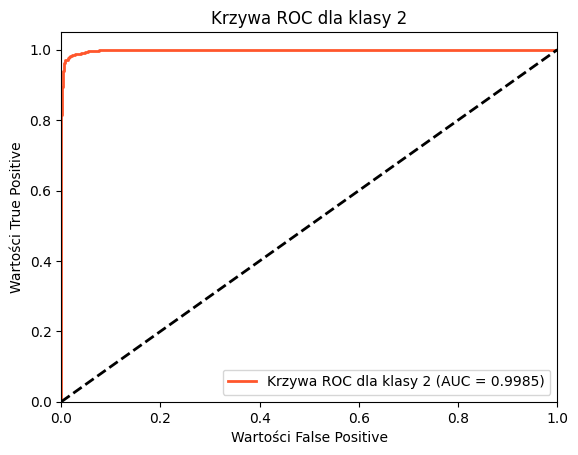


 ----------------------------------------  Metryki pomiarowe VGG16/2  ---------------------------------------- 

Precision: 0.9669853637141628
Recall: 0.9672119635723977
F1 Score: 0.9670586546565308

 ----------------------------------------   Model VGG16/3  ---------------------------------------- 


 ----------------------------------------  Tworzenie modelu VGG16/3  ---------------------------------------- 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None

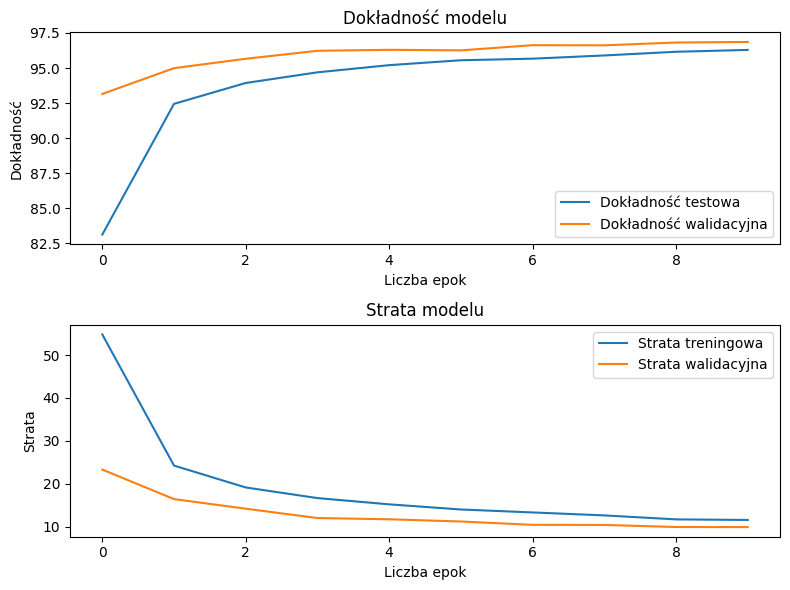


 ----------------------------------------  Testowanie modelu VGG16/3  ---------------------------------------- 

313/313 [==============================] - 2s 7ms/step
Prediction completed in: 2.43 seconds

 ----------------------------------------  Macierz pomyłek VGG16/3  ---------------------------------------- 



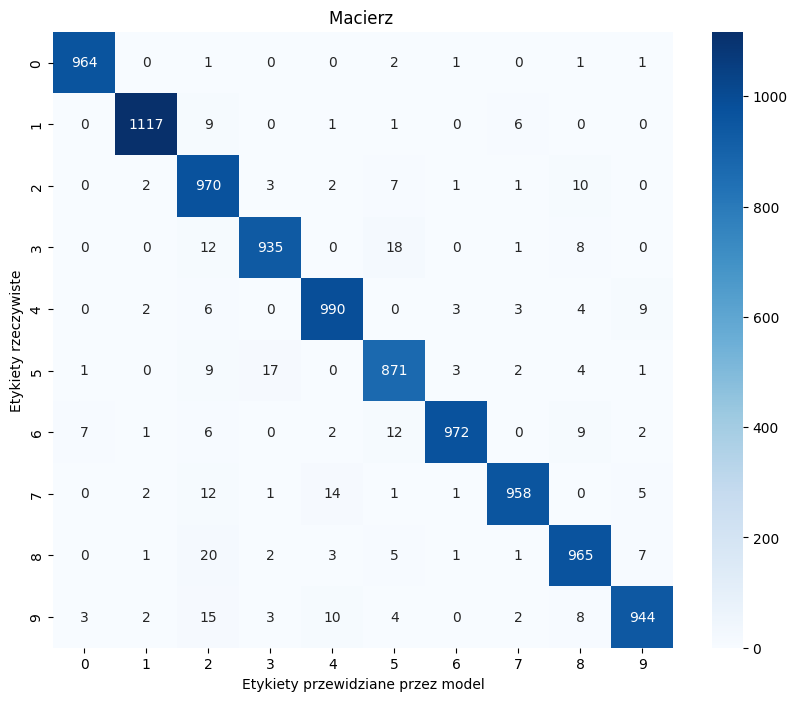


 ----------------------------------------  AUC i ROC VGG16/3  ---------------------------------------- 

Average AUC: 0.9993

AUC for class 0: 99.992
AUC for class 1: 99.991
AUC for class 2: 99.876
AUC for class 3: 99.919
AUC for class 4: 99.929
AUC for class 5: 99.896
AUC for class 6: 99.981
AUC for class 7: 99.96
AUC for class 8: 99.885
AUC for class 9: 99.905


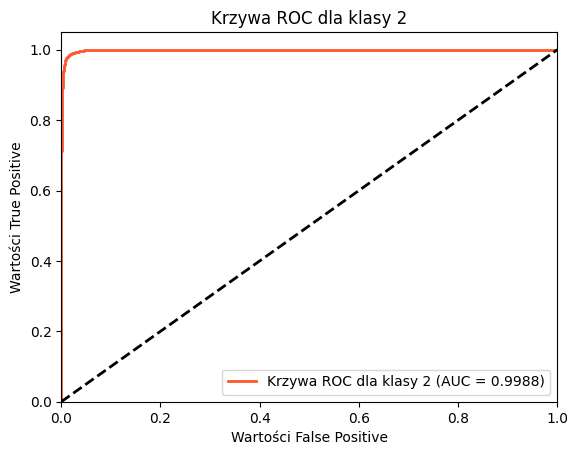


 ----------------------------------------  Metryki pomiarowe VGG16/3  ---------------------------------------- 

Precision: 0.9686266321966738
Recall: 0.9683359386576799
F1 Score: 0.9683351774332521

 ----------------------------------------   Model VGG16/4  ---------------------------------------- 


 ----------------------------------------  Tworzenie modelu VGG16/4  ---------------------------------------- 

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (Non

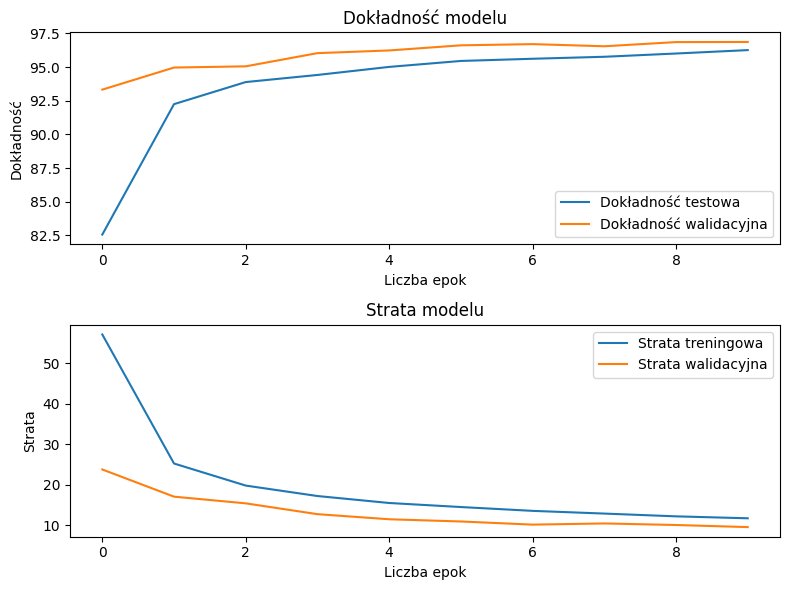


 ----------------------------------------  Testowanie modelu VGG16/4  ---------------------------------------- 

313/313 [==============================] - 2s 7ms/step
Prediction completed in: 2.42 seconds

 ----------------------------------------  Macierz pomyłek VGG16/4  ---------------------------------------- 



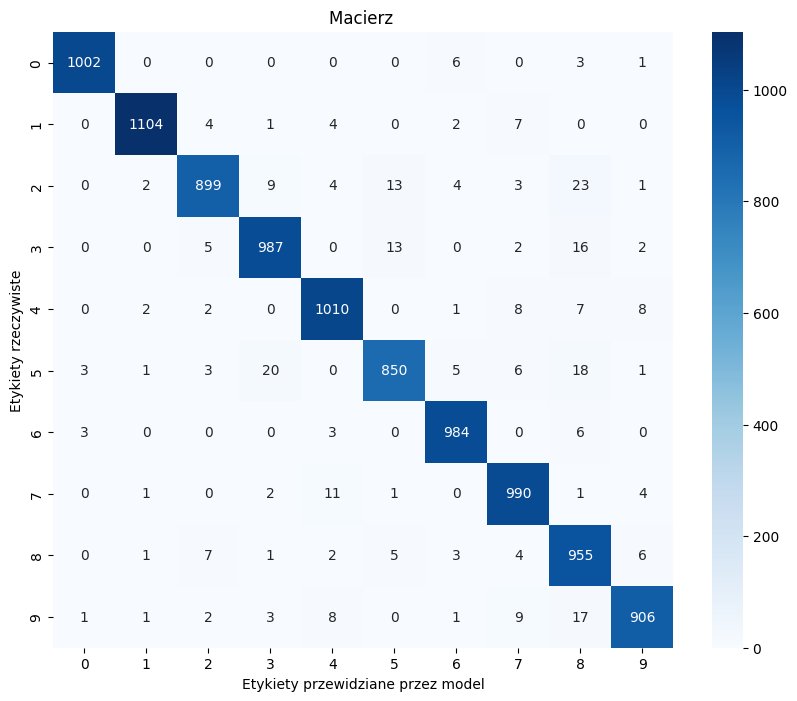


 ----------------------------------------  AUC i ROC VGG16/4  ---------------------------------------- 

Average AUC: 0.9993

AUC for class 0: 99.991
AUC for class 1: 99.988
AUC for class 2: 99.902
AUC for class 3: 99.894
AUC for class 4: 99.95
AUC for class 5: 99.85
AUC for class 6: 99.974
AUC for class 7: 99.968
AUC for class 8: 99.88
AUC for class 9: 99.92


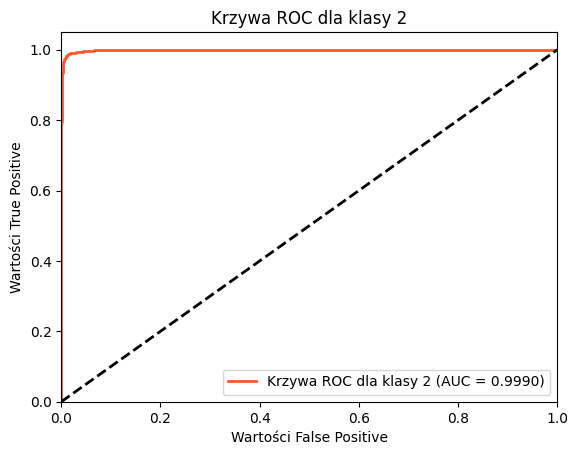


 ----------------------------------------  Metryki pomiarowe VGG16/4  ---------------------------------------- 

Precision: 0.9687214901712828
Recall: 0.9679970977332852
F1 Score: 0.968194375665564


In [75]:
from collections import defaultdict

SIZE, EPOCHS = 50000, 10
output_data = defaultdict()

for i in range(1, 5):

    print('\n', '-'*40, f'{Fore.RED}  Model VGG16/{i} {Fore.BLACK}', '-'*40, '\n')

    # Wybór odpowiedniej ilosci danych
    sampled_images, sampled_labels = shuffle_data(images, labels, seeds[i], SIZE)

    # Wstępne przetwarzanie danych
    images_resized = resize_images(sampled_images, [32, 32])

    # Przygotowanie etykiet
    y_one_hot = keras.utils.to_categorical(sampled_labels, 10)

    # Podział przygotowanych danych w stosunku 80/20
    split_index = int(len(images_resized) * 0.8)
    x_train, x_test = images_resized[:split_index], images_resized[split_index:]
    y_train, y_test = y_one_hot[:split_index], y_one_hot[split_index:]

    print('\n', '-'*40, f'{Fore.GREEN} Tworzenie modelu VGG16/{i} {Fore.BLACK}', '-'*40, '\n')

    # Stwórz model i zacznij trening
    VGG16_model = build_VGG_model('VGG16')

    print('\n', '-'*40, f'{Fore.GREEN} Trening modelu VGG16/{i} {Fore.BLACK}', '-'*40, '\n')

    history, training_time = train_model(model = VGG16_model,
                                         x_train = x_train,
                                         y_train = y_train,
                                         val_data = (x_test, y_test),
                                         epochs = EPOCHS)

    print('\n', '-'*40, f'{Fore.GREEN}Dokładność i strata modelu VGG16/{i} na wykresach {Fore.BLACK}', '-'*40, '\n')

    plot_accuracy_and_loss(history)

    print('\n', '-'*40, f'{Fore.GREEN} Testowanie modelu VGG16/{i} {Fore.BLACK}', '-'*40, '\n')

    predictions, predicting_time  = predict(VGG16_model, x_test)

    # Convert predictions and y_test to class labels
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    output_data[i] = [training_time,
                      predicting_time,
                      history.history['accuracy'][-1],
                      history.history['val_accuracy'][-1],
                      history.history['loss'][-1],
                      history.history['val_loss'][-1]]

    print('\n', '-'*40, f'{Fore.GREEN} Macierz pomyłek VGG16/{i} {Fore.BLACK}', '-'*40, '\n')

    custom_confusion_matrix(true_classes, predicted_classes)

    print('\n', '-'*40, f'{Fore.GREEN} AUC i ROC VGG16/{i} {Fore.BLACK}', '-'*40, '\n')

    roc_auc, fpr, tpr = area_under_the_curve(predictions)
    ROC_curve(roc_auc, fpr, tpr)

    print('\n', '-'*40, f'{Fore.GREEN} Metryki pomiarowe VGG16/{i} {Fore.BLACK}', '-'*40, '\n',)

    compute_metrics(true_classes, predicted_classes)

    del sampled_images, sampled_labels, VGG16_model, history, training_time
